# Checking quality of amino acids embeddings

## Checking quality for epitopes

### Import libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from umap import UMAP
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import sys
import os
from IPython import get_ipython
from pathlib import Path

notebook_path = get_ipython().run_line_magic("pwd", "")
project_root = Path(notebook_path).parent.parent.parent
sys.path.append(str(project_root)) 
from modules.modules_kidera.kidera import kidera_final_dict
np.random.seed(42)

### Load Data and create amino acid mapping

In [3]:
decoded_epitope = np.load('../../../datasets/datasets_kidera/check_quality/decoded_epitope.npy')
epitopes = pd.read_csv('../../../datasets/datasets_kidera/check_quality/epitopes_quality.csv')['antigen_epitope'].str.cat(sep='')

coloring={x:i for i,x in enumerate(kidera_final_dict.keys())}

### Process Data

In [4]:
data = []
for num, seq_tensor in enumerate(decoded_epitope):
    seq = seq_tensor.squeeze(0).T
    data.extend(np.column_stack([seq, np.full(len(seq), coloring[epitopes[num]])]))
                
df = pd.DataFrame(data)
df[10] = df[10].astype(int)
target = df[10]

### Sample Data

In [5]:
df_sampled = df.groupby(10, group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), 20000), random_state=42)
)

### Umap constructing

In [ ]:
umap= UMAP(n_neighbors=10, min_dist=0.3, n_jobs=-1, verbose=True).fit(df_sampled)

UMAP(min_dist=0.3, n_neighbors=10, verbose=True)
Sat May 24 22:57:37 2025 Construct fuzzy simplicial set


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Sat May 24 22:57:38 2025 Finding Nearest Neighbors
Sat May 24 22:57:38 2025 Building RP forest with 35 trees
Sat May 24 22:57:44 2025 NN descent for 18 iterations
	 1  /  18
	 2  /  18
	 3  /  18
	Stopping threshold met -- exiting after 3 iterations
Sat May 24 22:58:06 2025 Finished Nearest Neighbor Search
Sat May 24 22:58:10 2025 Construct embedding


/home/mbelyakov/.conda/envs/env1/lib/python3.8/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/mbelyakov/.conda/envs/env1/lib/python3.8/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


### Umap visualization

Epochs completed:   0%|            0/30 [00:00]

	completed  0  /  30 epochs


Epochs completed:  13%| █▎         4/30 [00:02]

	completed  3  /  30 epochs


Epochs completed:  23%| ██▎        7/30 [00:04]

	completed  6  /  30 epochs


Epochs completed:  33%| ███▎       10/30 [00:07]

	completed  9  /  30 epochs


Epochs completed:  43%| ████▎      13/30 [00:09]

	completed  12  /  30 epochs


Epochs completed:  53%| █████▎     16/30 [00:12]

	completed  15  /  30 epochs


Epochs completed:  63%| ██████▎    19/30 [00:14]

	completed  18  /  30 epochs


Epochs completed:  73%| ███████▎   22/30 [00:17]

	completed  21  /  30 epochs


Epochs completed:  83%| ████████▎  25/30 [00:19]

	completed  24  /  30 epochs


Epochs completed:  93%| █████████▎ 28/30 [00:22]

	completed  27  /  30 epochs


Epochs completed: 100%| ██████████ 30/30 [00:23]


[Text(0.5, 0, 'UMAP 1'),
 Text(0, 0.5, 'UMAP 2'),
 Text(0.5, 1.0, 'UMAP for decoded embeddings of amino acids')]

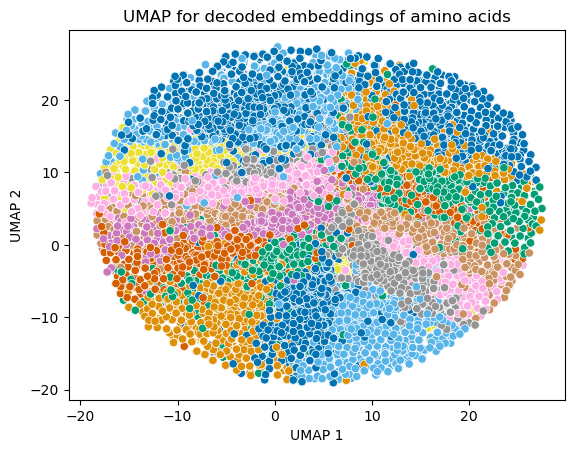

In [84]:
umap_embedding=umap.transform(df)
sns.scatterplot(
    x=umap_embedding[:, 0],
    y=umap_embedding[:, 1],
    hue=target,
    palette="colorblind",
    legend=False
).set(
    xlabel="UMAP 1",
    ylabel="UMAP 2",
    title="UMAP for decoded embeddings of amino acids"
)

In [35]:
np.save('../../../datasets/datasets_kidera/check_quality/umap_embedding.npy',umap_embedding)

In [5]:
umap_embedding=np.load('../../../datasets/datasets_kidera/check_quality/umap_embedding.npy')

### Classification

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    umap_embedding, target, test_size=0.3, random_state=42
)
model = RandomForestClassifier(n_estimators=20)
model.fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12855
           1       0.99      0.99      0.99      7684
           2       0.99      0.99      0.99      5698
           3       0.99      0.99      0.99      4833
           4       0.99      0.98      0.98      1616
           5       0.99      0.99      0.99      5185
           6       0.99      0.98      0.99      4116
           7       0.99      1.00      1.00     13773
           8       0.98      0.98      0.98      1567
           9       1.00      1.00      1.00     10994
          10       1.00      1.00      1.00     27226
          11       0.99      0.99      0.99      8471
          12       0.99      0.99      0.99      5851
          13       0.99      0.99      0.99     12232
          14       0.99      0.99      0.99      8760
          15       0.99      0.99      0.99      6148
          16       0.99      0.99      0.99     14294
          17       0.99    

### Counting error rate

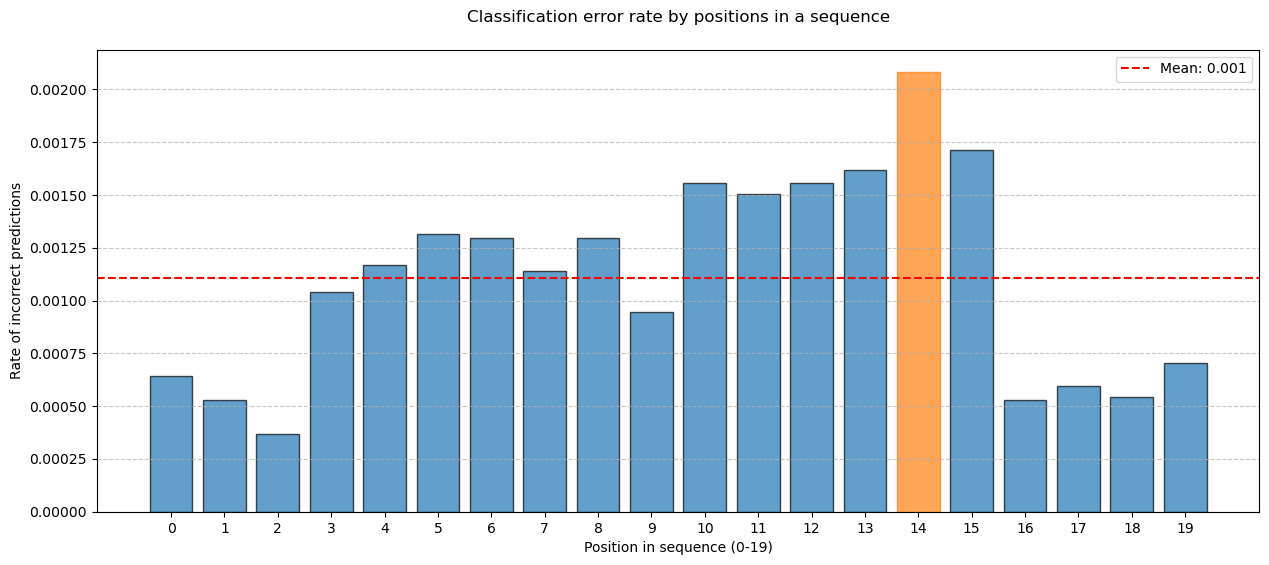

Positions with the largest errors:
Position 14: 0.2% errors
Position 15: 0.2% errors
Position 13: 0.2% errors
Position 12: 0.2% errors
Position 10: 0.2% errors


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

#1. Data preparation (similar)
def prepare_data(X, y, window_size=20):
    """Splits data into fixed-size windows"""    
    n_windows = len(X) // window_size
    X_windowed = X[:n_windows * window_size].reshape(n_windows, window_size, 2)
    y_windowed = y[:n_windows * window_size].reshape(n_windows, window_size)
    return X_windowed, y_windowed

#2. Calculating errors by positions (adapted for classification)
def calculate_position_errors(model, X_windowed, y_windowed):
    """Calculates the error rate for each position in the window"""
    n_windows, window_size, _ = X_windowed.shape
    error_counts = np.zeros(window_size)
    
    for i in range(n_windows):
        X_batch = X_windowed[i]
        y_batch = y_windowed[i]
        preds = model.predict(X_batch)
        error_counts += (preds != y_batch)  
        
    return error_counts / n_windows  

#3. Visualization (adapted)
def plot_error_distribution(error_rates, window_size=20):
    """Plots a histogram of error rates by position"""
    plt.figure(figsize=(15, 6))
    
    bars = plt.bar(range(window_size), error_rates, 
                  color='#1f77b4', alpha=0.7,
                  edgecolor='black')
    
    max_idx = np.argmax(error_rates)
    bars[max_idx].set_color('#ff7f0e')
    
    # Annotations
    plt.title('Classification error rate by positions in a sequence', pad=20)
    plt.xlabel('Position in sequence (0-19)')
    plt.ylabel('Rate of incorrect predictions')
    plt.xticks(range(window_size))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    mean_rate = np.mean(error_rates)
    plt.axhline(mean_rate, color='red', linestyle='--', 
               label=f'Mean: {mean_rate:.3f}')
    plt.legend()
    
    plt.show()

# Main function
def analyze_classifier_errors(X, y, model, window_size=20):
    """Analysis of classifier errors by positions"""
    X_windowed, y_windowed = prepare_data(X, y, window_size)
    error_rates = calculate_position_errors(model, X_windowed, y_windowed)
    plot_error_distribution(error_rates, window_size)
    
    # Returning positions with the largest errors (top 5)
    worst_positions = np.argsort(error_rates)[-5:][::-1]
    print("Positions with the largest errors:")
    for pos in worst_positions:
        print(f"Position {pos}: {error_rates[pos]:.1%} errors")
    
    return error_rates
    
    
error_rates = analyze_classifier_errors(umap_embedding, np.array(target.values), model)

## Checking quality for cdr3 

### Load Data and create amino acids mapping

In [21]:
decoded_cdr3 = np.load('../../../datasets/datasets_kidera/check_quality/decoded_cdr3.npy')
cdrs = pd.read_csv('../../../datasets/datasets_kidera/check_quality/cdr3_quality.csv')['cdr3'].str.cat(sep='')

coloring={x:i for i,x in enumerate(kidera_final_dict.keys())}

### Data preparation

In [22]:
data = []
for num, seq_tensor in enumerate(decoded_cdr3):
    seq = seq_tensor.squeeze(0).T
    data.extend(np.column_stack([seq, np.full(len(seq), coloring[cdrs[num]])]))
                
df = pd.DataFrame(data)
df[10] = df[10].astype(int)
target = df[10]

### Sampling data

In [23]:
df_sampled = df.groupby(10, group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), 20000), random_state=42)
)

### Umap building

In [24]:
umap= UMAP(n_neighbors=10, min_dist=0.3, n_jobs=-1, verbose=True).fit(df_sampled)

UMAP(min_dist=0.3, n_neighbors=10, verbose=True)
Fri May 16 15:40:15 2025 Construct fuzzy simplicial set
Fri May 16 15:40:15 2025 Finding Nearest Neighbors
Fri May 16 15:40:15 2025 Building RP forest with 35 trees
Fri May 16 15:40:17 2025 NN descent for 18 iterations
	 1  /  18
	 2  /  18
	 3  /  18
	 4  /  18
	Stopping threshold met -- exiting after 4 iterations
Fri May 16 15:40:30 2025 Finished Nearest Neighbor Search
Fri May 16 15:40:32 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs


Epochs completed:  11%| █          22/200 [00:03]

	completed  20  /  200 epochs


Epochs completed:  21%| ██         42/200 [00:07]

	completed  40  /  200 epochs


Epochs completed:  31%| ███        62/200 [00:10]

	completed  60  /  200 epochs


Epochs completed:  41%| ████       82/200 [00:14]

	completed  80  /  200 epochs


Epochs completed:  51%| █████      102/200 [00:18]

	completed  100  /  200 epochs


Epochs completed:  61%| ██████     122/200 [00:22]

	completed  120  /  200 epochs


Epochs completed:  71%| ███████    142/200 [00:25]

	completed  140  /  200 epochs


Epochs completed:  81%| ████████   162/200 [00:29]

	completed  160  /  200 epochs


Epochs completed:  91%| █████████  182/200 [00:33]

	completed  180  /  200 epochs


Epochs completed: 100%| ██████████ 200/200 [00:36]


Fri May 16 15:42:48 2025 Finished embedding


### Umap visualization

Fri May 16 15:46:07 2025 Worst tree score: 0.68238325
Fri May 16 15:46:07 2025 Mean tree score: 0.69397502
Fri May 16 15:46:07 2025 Best tree score: 0.70340028
Fri May 16 15:46:10 2025 Forward diversification reduced edges from 3536180 to 2427562
Fri May 16 15:46:10 2025 Reverse diversification reduced edges from 2427562 to 2427562
Fri May 16 15:46:10 2025 Degree pruning reduced edges from 2627828 to 2618219
Fri May 16 15:46:10 2025 Resorting data and graph based on tree order
Fri May 16 15:46:11 2025 Building and compiling search function


Epochs completed:   0%|            0/30 [00:00]

	completed  0  /  30 epochs


Epochs completed:  13%| █▎         4/30 [00:01]

	completed  3  /  30 epochs


Epochs completed:  23%| ██▎        7/30 [00:02]

	completed  6  /  30 epochs


Epochs completed:  33%| ███▎       10/30 [00:04]

	completed  9  /  30 epochs


Epochs completed:  43%| ████▎      13/30 [00:06]

	completed  12  /  30 epochs


Epochs completed:  53%| █████▎     16/30 [00:08]

	completed  15  /  30 epochs


Epochs completed:  63%| ██████▎    19/30 [00:09]

	completed  18  /  30 epochs


Epochs completed:  73%| ███████▎   22/30 [00:11]

	completed  21  /  30 epochs


Epochs completed:  83%| ████████▎  25/30 [00:13]

	completed  24  /  30 epochs


Epochs completed:  93%| █████████▎ 28/30 [00:14]

	completed  27  /  30 epochs


Epochs completed: 100%| ██████████ 30/30 [00:16]


[Text(0.5, 0, 'UMAP 1'),
 Text(0, 0.5, 'UMAP 2'),
 Text(0.5, 1.0, 'UMAP for decoded embeddings of amino acids')]

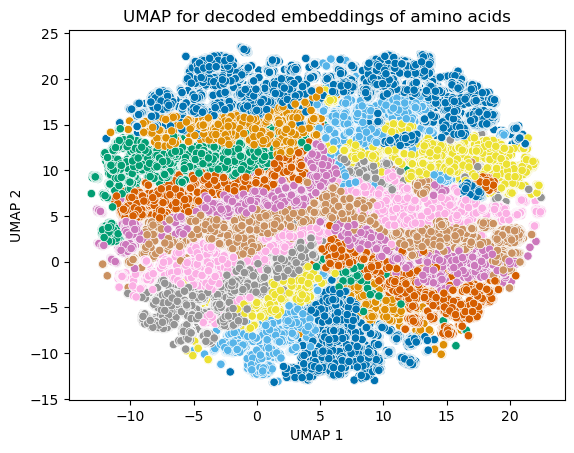

In [25]:
umap_embedding=umap.transform(df)
sns.scatterplot(
    x=umap_embedding[:, 0],
    y=umap_embedding[:, 1],
    hue=target,
    palette="colorblind",
    legend=False
).set(
    xlabel="UMAP 1",
    ylabel="UMAP 2",
    title="UMAP for decoded embeddings of amino acids"
)

### Classification

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    umap_embedding, target, test_size=0.3, random_state=42
)
model = RandomForestClassifier(n_estimators=20)
model.fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27911
           1       0.99      1.00      0.99      8231
           2       1.00      1.00      1.00      8056
           3       0.99      0.99      0.99      7869
           4       0.99      1.00      1.00     18894
           5       1.00      1.00      1.00     17951
           6       0.99      0.99      0.99     15581
           7       1.00      1.00      1.00     27022
           8       0.99      0.98      0.98      2994
           9       1.00      1.00      1.00      3437
          10       1.00      1.00      1.00     11583
          11       0.99      0.99      0.99      1846
          12       0.98      0.97      0.98      1053
          13       1.00      1.00      1.00     28797
          14       0.99      0.98      0.98      7579
          15       1.00      1.00      1.00     41387
          16       1.00      1.00      1.00     17161
          17       0.99    

### Saving results

In [27]:
np.save('../../../datasets/datasets_kidera/check_quality/umap_embedding_cdr3.npy',umap_embedding)

In [28]:
umap_embedding=np.load('../../../datasets/datasets_kidera/check_quality/umap_embedding_cdr3.npy')

### Counting error rate

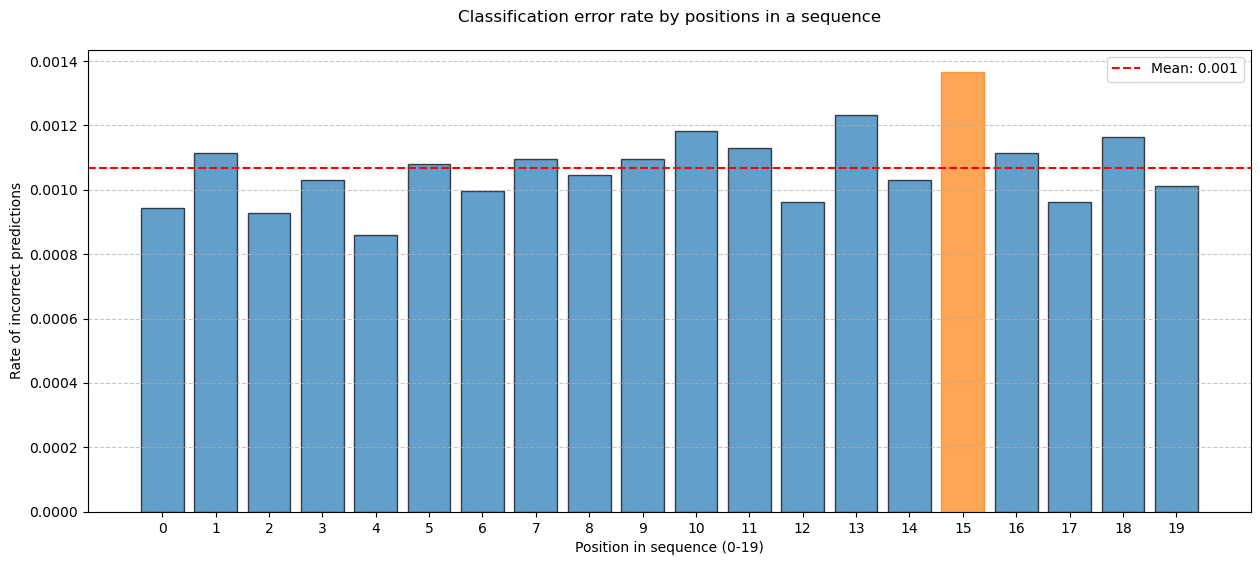

Positions with the largest errors:
Position 15: 0.1% errors
Position 13: 0.1% errors
Position 10: 0.1% errors
Position 18: 0.1% errors
Position 11: 0.1% errors


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

#1. Data preparation (similar)
def prepare_data(X, y, window_size=20):
    """Splits data into fixed-size windows"""    
    n_windows = len(X) // window_size
    X_windowed = X[:n_windows * window_size].reshape(n_windows, window_size, 2)
    y_windowed = y[:n_windows * window_size].reshape(n_windows, window_size)
    return X_windowed, y_windowed

#2. Calculating errors by positions (adapted for classification)
def calculate_position_errors(model, X_windowed, y_windowed):
    """Calculates the error rate for each position in the window"""
    n_windows, window_size, _ = X_windowed.shape
    error_counts = np.zeros(window_size)
    
    for i in range(n_windows):
        X_batch = X_windowed[i]
        y_batch = y_windowed[i]
        preds = model.predict(X_batch)
        error_counts += (preds != y_batch)  
        
    return error_counts / n_windows  

#3. Visualization (adapted)
def plot_error_distribution(error_rates, window_size=20):
    """Plots a histogram of error rates by position"""
    plt.figure(figsize=(15, 6))
    
    bars = plt.bar(range(window_size), error_rates, 
                  color='#1f77b4', alpha=0.7,
                  edgecolor='black')
    
    max_idx = np.argmax(error_rates)
    bars[max_idx].set_color('#ff7f0e')
    
    # Annotations
    plt.title('Classification error rate by positions in a sequence', pad=20)
    plt.xlabel('Position in sequence (0-19)')
    plt.ylabel('Rate of incorrect predictions')
    plt.xticks(range(window_size))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    mean_rate = np.mean(error_rates)
    plt.axhline(mean_rate, color='red', linestyle='--', 
               label=f'Mean: {mean_rate:.3f}')
    plt.legend()
    
    plt.show()

# Main function
def analyze_classifier_errors(X, y, model, window_size=20):
    """Analysis of classifier errors by positions"""
    X_windowed, y_windowed = prepare_data(X, y, window_size)
    error_rates = calculate_position_errors(model, X_windowed, y_windowed)
    plot_error_distribution(error_rates, window_size)
    
    # Returning positions with the largest errors (top 5)
    worst_positions = np.argsort(error_rates)[-5:][::-1]
    print("Positions with the largest errors:")
    for pos in worst_positions:
        print(f"Position {pos}: {error_rates[pos]:.1%} errors")
    
    return error_rates
    
    
error_rates = analyze_classifier_errors(umap_embedding, np.array(target.values), model)